# Exploring `cactice`

This notebook demonstrates basic `cactice` usage and explores some use cases.

## Reading data into `cactice`

First we review the formats `cactice` supports and demonstrate how to read some sample data. `cactice` currently supports 2 formats:

- comma- or tab-delimited data (CSV/TSV)
- text grids (2D character arrays)

### CSV files

`cactice` can read 1 or more grids from a CSV or TSV file containing columns for:

- grid index
- class label
- row index
- column index

By default `cactice` expects to find columns named `Grid`, `Class`, `I`, and `J`, respectively. Alternative mappings can also be provided. Note that the file *must* begin with a header row.

For instance, to read in some sample grids from a CSV file:

In [1]:
from typing import Dict
import numpy as np
from cactice.fileio import read_grids_csv

grids: Dict[str, np.ndarray] = read_grids_csv('../testdata/grids.csv')

### Text files

`cactice` can also read a single grid from a text file. The text is interpreted as a 2-dimensional character array, with newlines delimiting rows and each distinct character a class.

For instance:

In [2]:
from cactice.fileio import read_grid_txt

grids['from_text'] = read_grid_txt('../testdata/grid.txt')

## Plotting grids

Now that we've loaded some grids into `cactice` we can take a look at them.

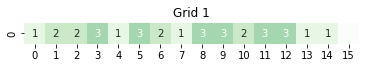

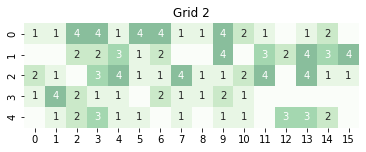

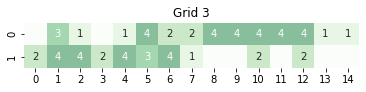

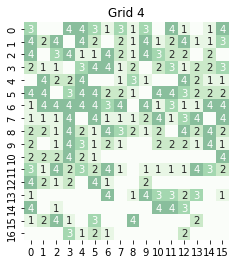

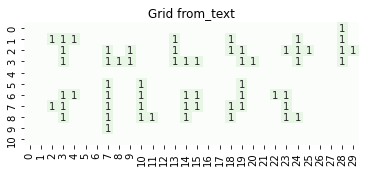

In [3]:
from cactice.plot import plot_grid

for name, grid in grids.items():
    plot_grid(grid, f"Grid {name}")

## Computing summary statistics

### Cell distribution

Now we'll calculate the grid cell class distribution overall and on a per-grid basis.

Overall cell distribution:
{0: 0.52198, 1: 0.21016, 2: 0.0989, 3: 0.05769, 4: 0.11126}


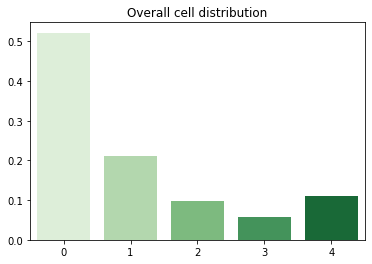

Grid 1 cell distribution:
{0: 0.0625, 1: 0.3125, 2: 0.25, 3: 0.375}


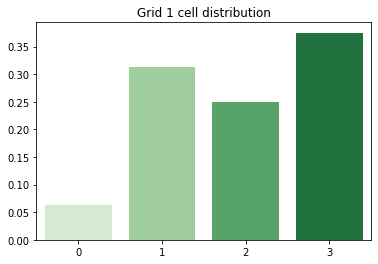

Grid 2 cell distribution:
{0: 0.25, 1: 0.3375, 2: 0.1625, 3: 0.0875, 4: 0.1625}


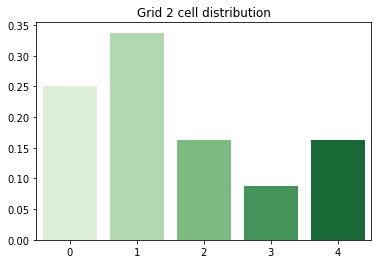

Grid 3 cell distribution:
{0: 0.23333, 1: 0.16667, 2: 0.2, 3: 0.06667, 4: 0.33333}


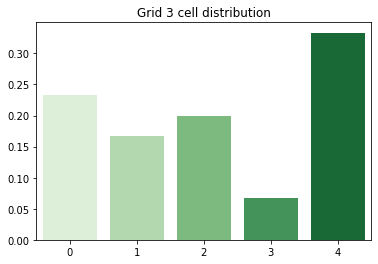

Grid 4 cell distribution:
{0: 0.30147, 1: 0.20588, 2: 0.18015, 3: 0.09926, 4: 0.21324}


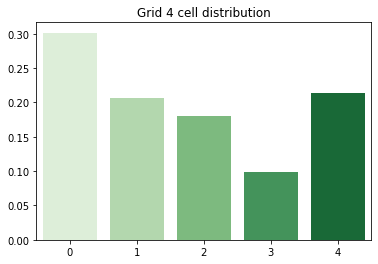

Grid from_text cell distribution:
{0: 0.82, 1: 0.18}


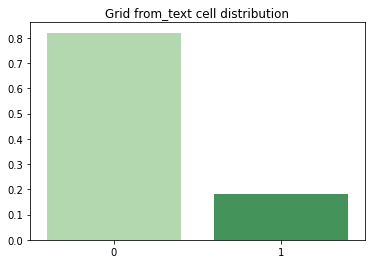

In [4]:
from pprint import pprint
import cactice.stats as stats
from cactice.plot import plot_cell_dist

grids_l = list(grids.values())
cell_dist = stats.cell_dist(grids_l)

title = "Overall cell distribution"
print(f"{title}:")
pprint(cell_dist)
plot_cell_dist(cell_dist, title)

for name, grid in grids.items():
    title = f"Grid {name} cell distribution"
    print(f"{title}:")
    grid_cell_dist = stats.cell_dist([grid])
    pprint(grid_cell_dist)
    plot_cell_dist(grid_cell_dist, title)

### Bond distribution

We can also take a look at the distribution of bonds (adjacencies) between grid cell classes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Overall undirected bonds (horizontal):
{'0-0': 0.3763779527559055,
 '0-1': 0.16535433070866143,
 '0-2': 0.05826771653543307,
 '0-3': 0.02204724409448819,
 '0-4': 0.05669291338582677,
 '1-0': 0.0,
 '1-1': 0.06929133858267716,
 '1-2': 0.04566929133858268,
 '1-3': 0.026771653543307086,
 '1-4': 0.050393700787401574,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.015748031496062992,
 '2-3': 0.023622047244094488,
 '2-4': 0.03622047244094488,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.0,
 '3-4': 0.025196850393700787,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.028346456692913385}


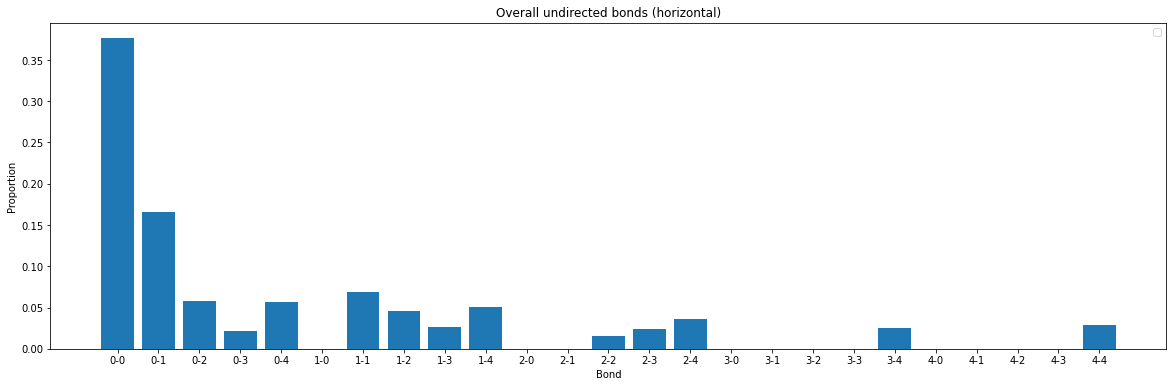

Overall undirected bonds (vertical):
{'0-0': 0.3901734104046243,
 '0-1': 0.16618497109826588,
 '0-2': 0.03757225433526012,
 '0-3': 0.02023121387283237,
 '0-4': 0.04190751445086705,
 '1-0': 0.0,
 '1-1': 0.06069364161849711,
 '1-2': 0.049132947976878616,
 '1-3': 0.030346820809248554,
 '1-4': 0.05635838150289017,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.02023121387283237,
 '2-3': 0.02601156069364162,
 '2-4': 0.04190751445086705,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.005780346820809248,
 '3-4': 0.02745664739884393,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.02601156069364162}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


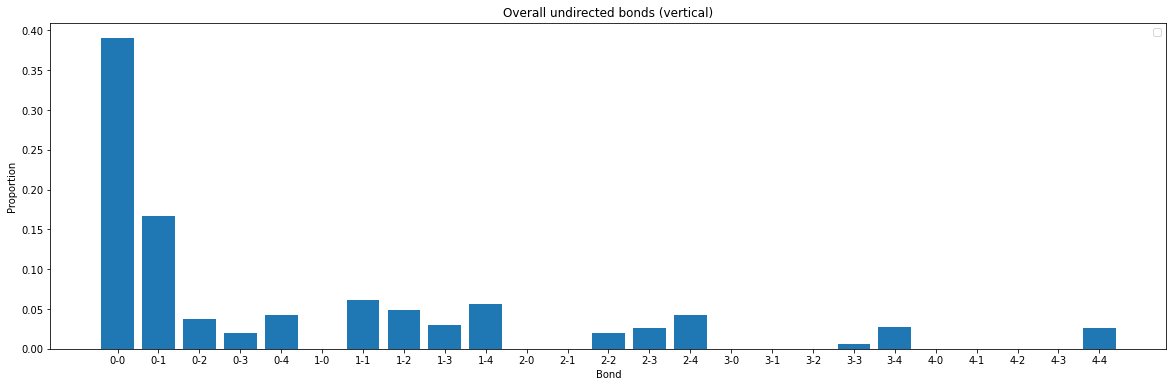

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Overall undirected bonds (combined):
{'0-0': 0.3901734104046243,
 '0-1': 0.16618497109826588,
 '0-2': 0.03757225433526012,
 '0-3': 0.02023121387283237,
 '0-4': 0.04190751445086705,
 '1-0': 0.0,
 '1-1': 0.06069364161849711,
 '1-2': 0.049132947976878616,
 '1-3': 0.030346820809248554,
 '1-4': 0.05635838150289017,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.02023121387283237,
 '2-3': 0.02601156069364162,
 '2-4': 0.04190751445086705,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.005780346820809248,
 '3-4': 0.02745664739884393,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.02601156069364162}


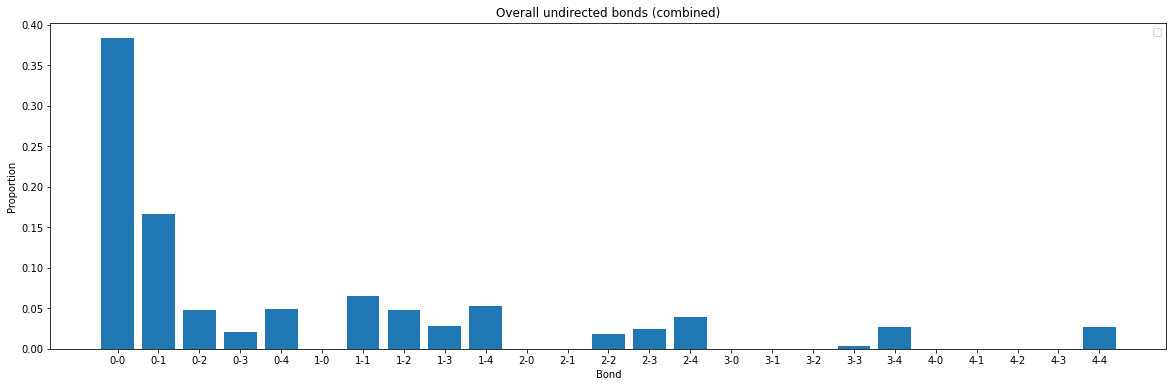

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '1' undirected bonds (horizontal):
{'0-0': 0,
 '0-1': 0,
 '0-2': 0,
 '0-3': 0,
 '1-0': 0,
 '1-1': 0,
 '1-2': 0,
 '1-3': 0,
 '2-0': 0,
 '2-1': 0,
 '2-2': 0,
 '2-3': 0,
 '3-0': 0,
 '3-1': 0,
 '3-2': 0,
 '3-3': 0}


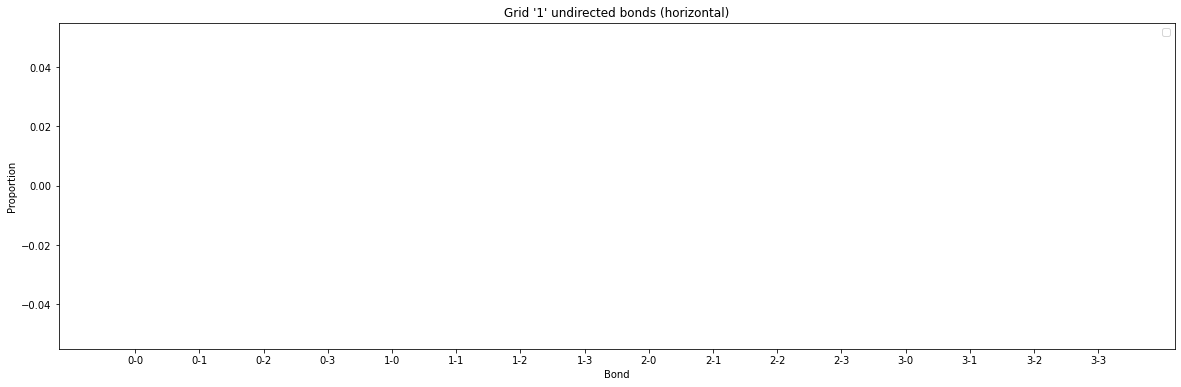

Grid '1' undirected bonds (vertical):
{'0-0': 0.0,
 '0-1': 0.0666666666666667,
 '0-2': 0.0,
 '0-3': 0.0,
 '1-0': 0.0,
 '1-1': 0.0666666666666667,
 '1-2': 0.1333333333333333,
 '1-3': 0.2666666666666667,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.0666666666666667,
 '2-3': 0.2666666666666667,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.1333333333333333}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


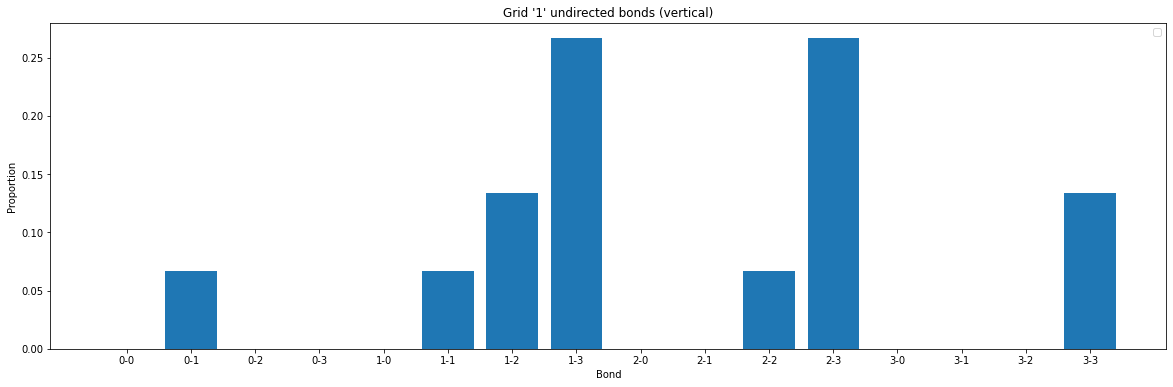

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '1' undirected bonds (combined):
{'0-0': 0.0,
 '0-1': 0.0666666666666667,
 '0-2': 0.0,
 '0-3': 0.0,
 '1-0': 0.0,
 '1-1': 0.0666666666666667,
 '1-2': 0.1333333333333333,
 '1-3': 0.2666666666666667,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.0666666666666667,
 '2-3': 0.2666666666666667,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.1333333333333333}


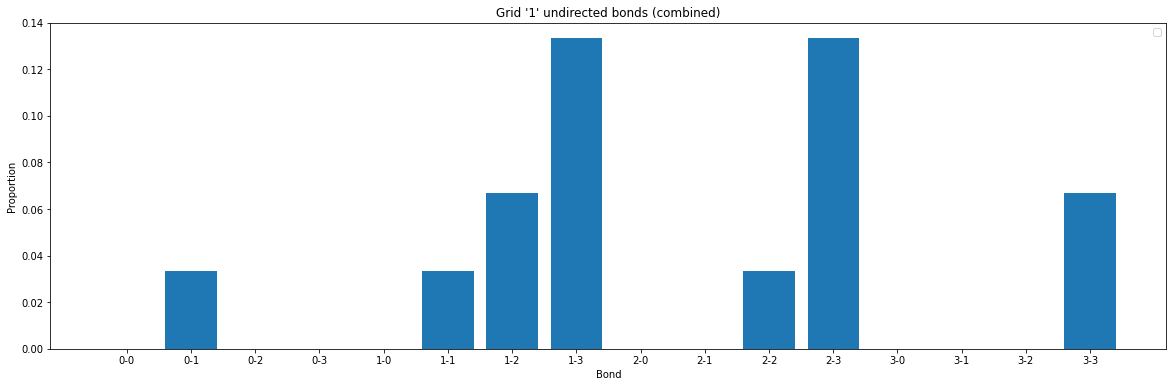

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '2' undirected bonds (horizontal):
{'0-0': 0.046875,
 '0-1': 0.1875,
 '0-2': 0.140625,
 '0-3': 0.03125,
 '0-4': 0.0625,
 '1-0': 0.0,
 '1-1': 0.078125,
 '1-2': 0.09375,
 '1-3': 0.078125,
 '1-4': 0.125,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.015625,
 '2-3': 0.03125,
 '2-4': 0.046875,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.0,
 '3-4': 0.03125,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.03125}


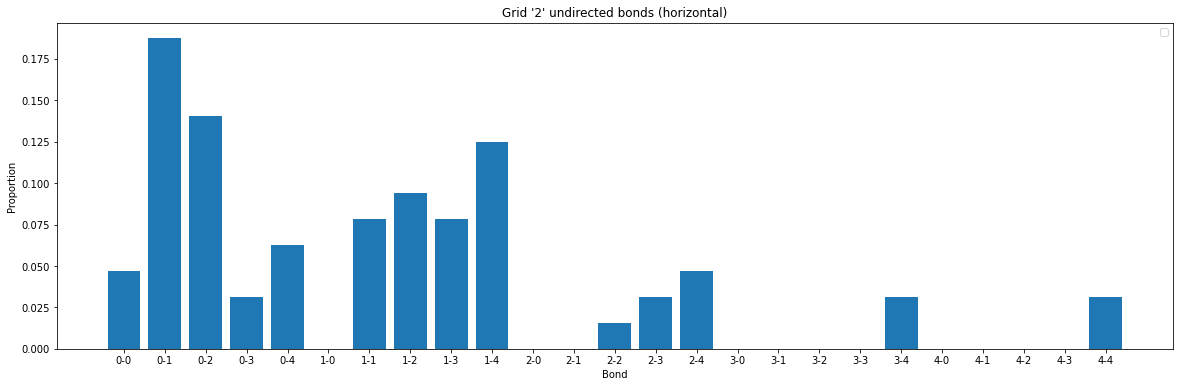

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '2' undirected bonds (vertical):
{'0-0': 0.08,
 '0-1': 0.14666666666666667,
 '0-2': 0.06666666666666667,
 '0-3': 0.04,
 '0-4': 0.05333333333333334,
 '1-0': 0.0,
 '1-1': 0.12,
 '1-2': 0.13333333333333333,
 '1-3': 0.02666666666666667,
 '1-4': 0.13333333333333333,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.013333333333333334,
 '2-3': 0.05333333333333334,
 '2-4': 0.05333333333333334,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.013333333333333334,
 '3-4': 0.04,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.02666666666666667}


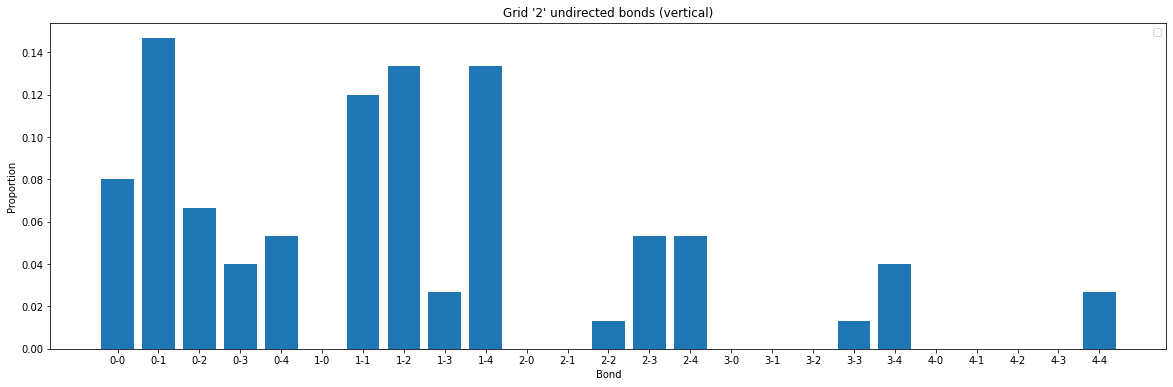

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '2' undirected bonds (combined):
{'0-0': 0.08,
 '0-1': 0.14666666666666667,
 '0-2': 0.06666666666666667,
 '0-3': 0.04,
 '0-4': 0.05333333333333334,
 '1-0': 0.0,
 '1-1': 0.12,
 '1-2': 0.13333333333333333,
 '1-3': 0.02666666666666667,
 '1-4': 0.13333333333333333,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.013333333333333334,
 '2-3': 0.05333333333333334,
 '2-4': 0.05333333333333334,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.013333333333333334,
 '3-4': 0.04,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.02666666666666667}


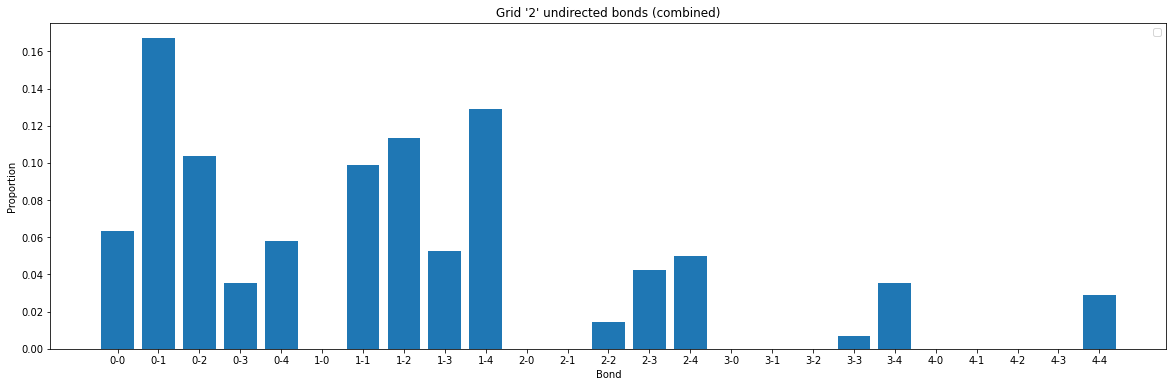

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '3' undirected bonds (horizontal):
{'0-0': 0.0,
 '0-1': 0.13333333333333333,
 '0-2': 0.13333333333333333,
 '0-3': 0.0,
 '0-4': 0.2,
 '1-0': 0.0,
 '1-1': 0.0,
 '1-2': 0.06666666666666667,
 '1-3': 0.0,
 '1-4': 0.13333333333333333,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.0,
 '2-3': 0.0,
 '2-4': 0.2,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.0,
 '3-4': 0.13333333333333333,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.0}


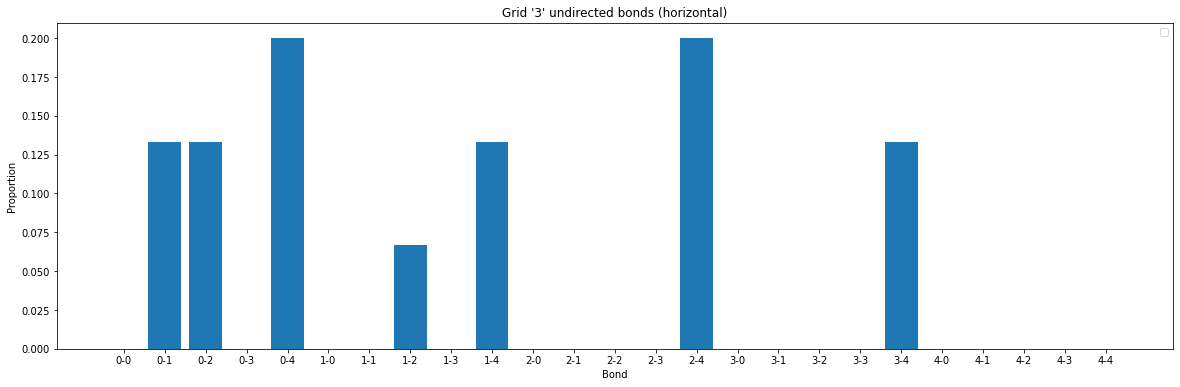

Grid '3' undirected bonds (vertical):
{'0-0': 0.07142857142857142,
 '0-1': 0.10714285714285714,
 '0-2': 0.14285714285714285,
 '0-3': 0.03571428571428571,
 '0-4': 0.0,
 '1-0': 0.0,
 '1-1': 0.03571428571428571,
 '1-2': 0.0,
 '1-3': 0.03571428571428571,
 '1-4': 0.10714285714285714,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.03571428571428571,
 '2-3': 0.0,
 '2-4': 0.17857142857142858,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.0,
 '3-4': 0.07142857142857142,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.17857142857142858}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


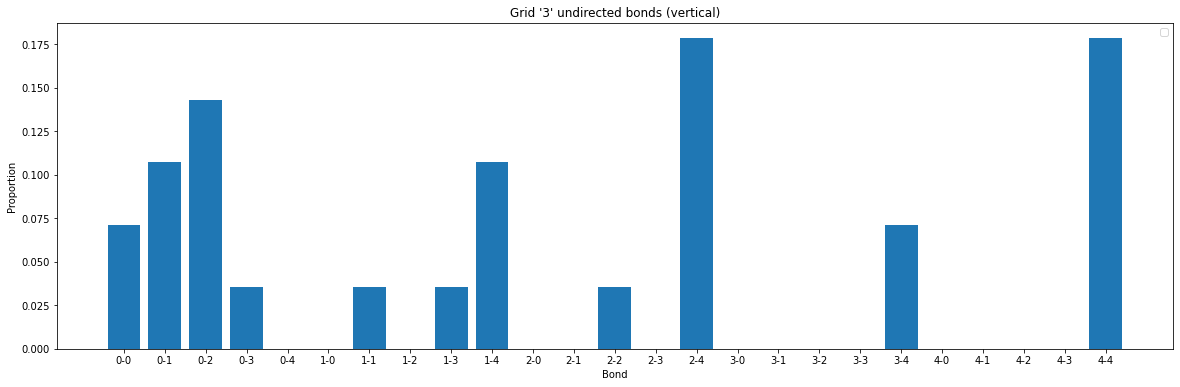

Grid '3' undirected bonds (combined):
{'0-0': 0.07142857142857142,
 '0-1': 0.10714285714285714,
 '0-2': 0.14285714285714285,
 '0-3': 0.03571428571428571,
 '0-4': 0.0,
 '1-0': 0.0,
 '1-1': 0.03571428571428571,
 '1-2': 0.0,
 '1-3': 0.03571428571428571,
 '1-4': 0.10714285714285714,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.03571428571428571,
 '2-3': 0.0,
 '2-4': 0.17857142857142858,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.0,
 '3-4': 0.07142857142857142,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.17857142857142858}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


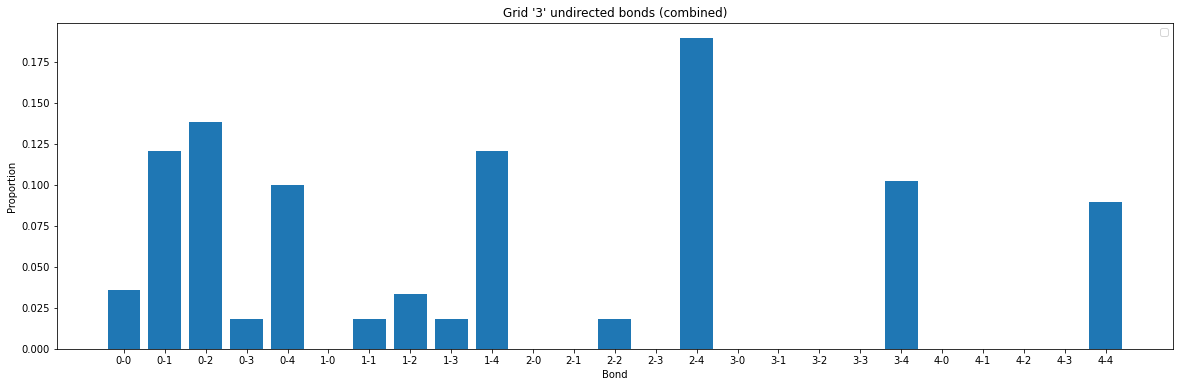

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '4' undirected bonds (horizontal):
{'0-0': 0.09765625,
 '0-1': 0.125,
 '0-2': 0.1015625,
 '0-3': 0.046875,
 '0-4': 0.11328125,
 '1-0': 0.0,
 '1-1': 0.03515625,
 '1-2': 0.0859375,
 '1-3': 0.046875,
 '1-4': 0.0859375,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.03515625,
 '2-3': 0.05078125,
 '2-4': 0.06640625,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.0,
 '3-4': 0.046875,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.0625}


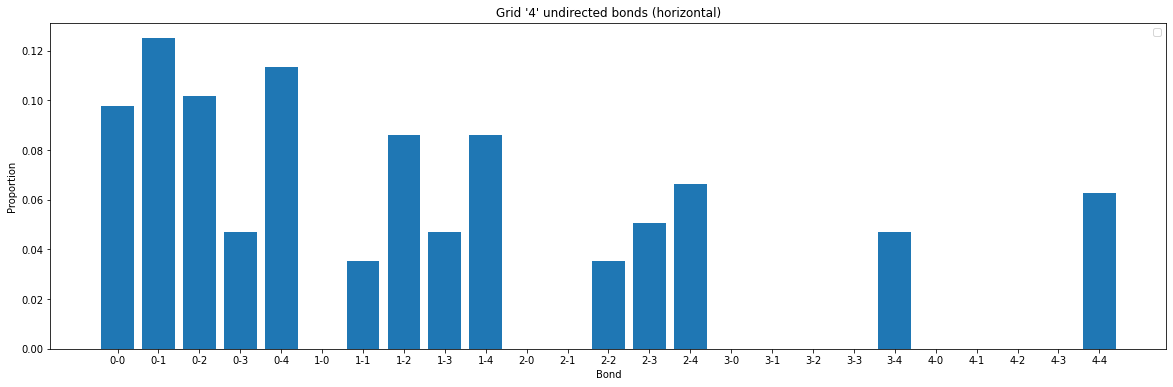

Grid '4' undirected bonds (vertical):
{'0-0': 0.16862745098039217,
 '0-1': 0.07450980392156863,
 '0-2': 0.06666666666666667,
 '0-3': 0.0392156862745098,
 '0-4': 0.09803921568627451,
 '1-0': 0.0,
 '1-1': 0.047058823529411764,
 '1-2': 0.08627450980392157,
 '1-3': 0.054901960784313725,
 '1-4': 0.10196078431372549,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.043137254901960784,
 '2-3': 0.0392156862745098,
 '2-4': 0.0784313725490196,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.00392156862745098,
 '3-4': 0.054901960784313725,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.043137254901960784}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


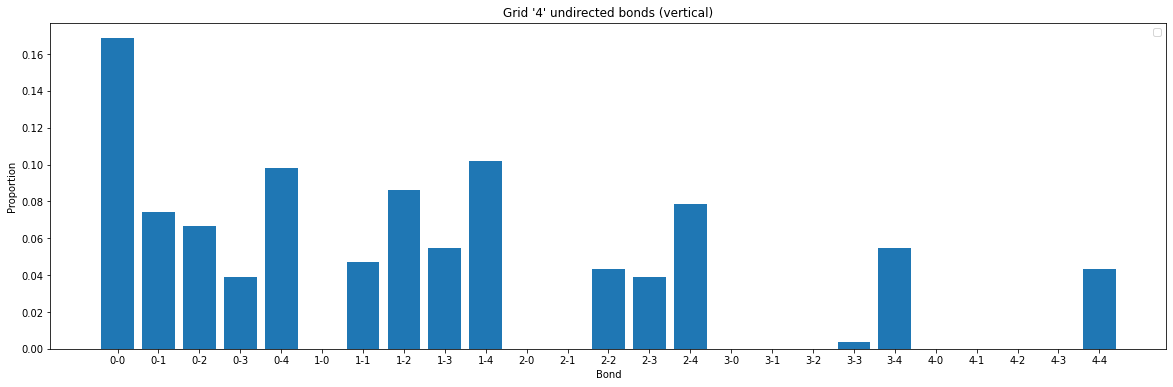

Grid '4' undirected bonds (combined):
{'0-0': 0.16862745098039217,
 '0-1': 0.07450980392156863,
 '0-2': 0.06666666666666667,
 '0-3': 0.0392156862745098,
 '0-4': 0.09803921568627451,
 '1-0': 0.0,
 '1-1': 0.047058823529411764,
 '1-2': 0.08627450980392157,
 '1-3': 0.054901960784313725,
 '1-4': 0.10196078431372549,
 '2-0': 0.0,
 '2-1': 0.0,
 '2-2': 0.043137254901960784,
 '2-3': 0.0392156862745098,
 '2-4': 0.0784313725490196,
 '3-0': 0.0,
 '3-1': 0.0,
 '3-2': 0.0,
 '3-3': 0.00392156862745098,
 '3-4': 0.054901960784313725,
 '4-0': 0.0,
 '4-1': 0.0,
 '4-2': 0.0,
 '4-3': 0.0,
 '4-4': 0.043137254901960784}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


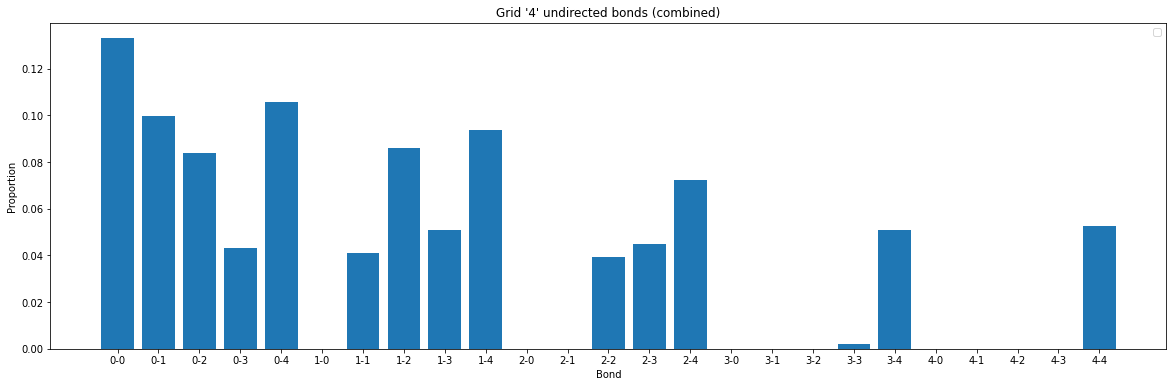

Grid 'from_text' undirected bonds (horizontal):
{'0-0': 0.7033, '0-1': 0.1967, '1-0': 0.0, '1-1': 0.1}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


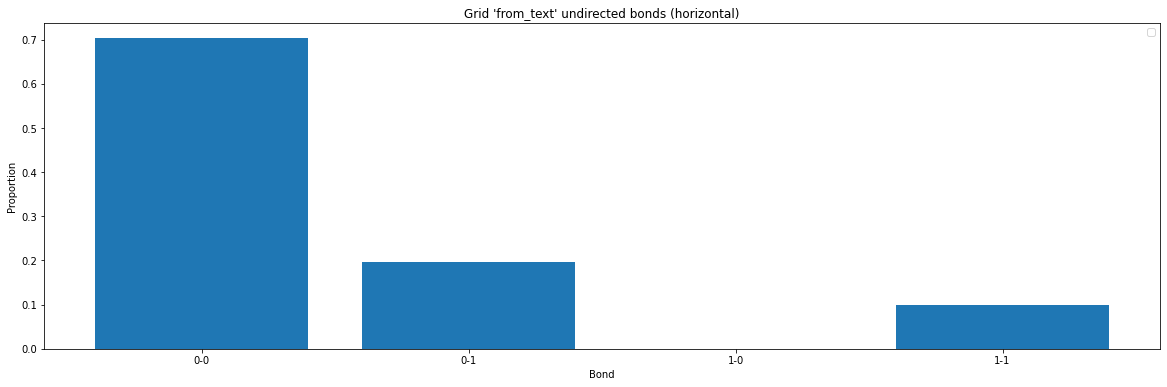

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid 'from_text' undirected bonds (vertical):
{'0-0': 0.6865, '0-1': 0.2539, '1-0': 0.0, '1-1': 0.0596}


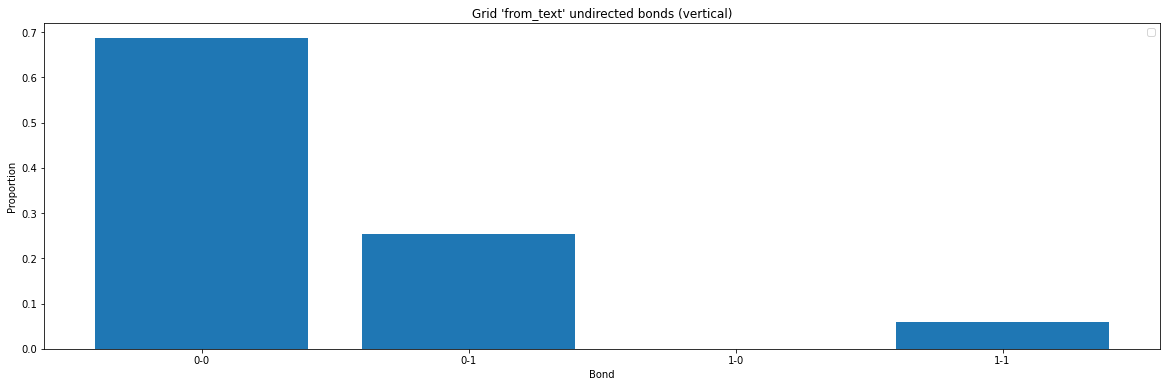

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid 'from_text' undirected bonds (combined):
{'0-0': 0.6865, '0-1': 0.2539, '1-0': 0.0, '1-1': 0.0596}


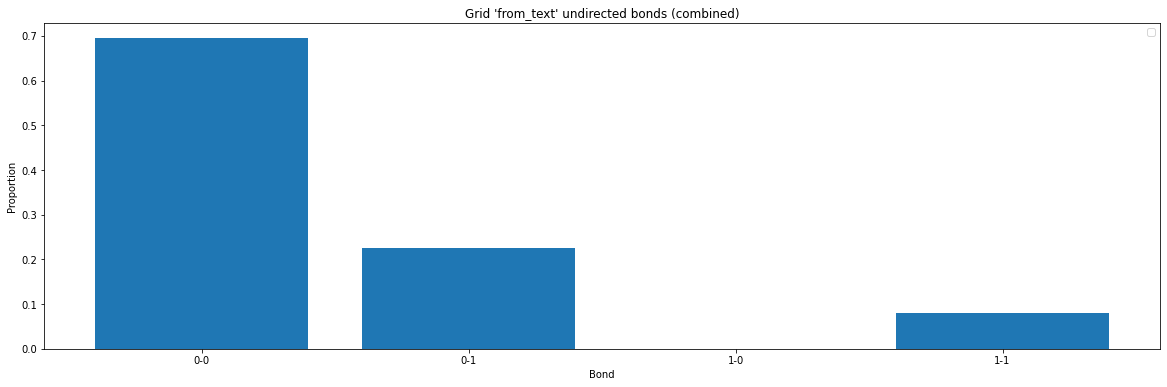

In [5]:
from cactice.plot import plot_undirected_bond_dist

bonds_h, bonds_v = stats.undirected_bond_dist(grids_l)

title = "Overall undirected bonds (horizontal)"
print(f"{title}:")
pprint(bonds_h)
plot_undirected_bond_dist(bonds_h, title)

title = "Overall undirected bonds (vertical)"
print(f"{title}:")
pprint(bonds_v)
plot_undirected_bond_dist(bonds_v, title)

bonds_c = {k: ((v + bonds_v[k]) / 2) for k, v in bonds_h.items()}

title = "Overall undirected bonds (combined)"
print(f"{title}:")
pprint(bonds_v)
plot_undirected_bond_dist(bonds_c, title)

for name, grid in grids.items():
    grid_bonds_h, grid_bonds_v = stats.undirected_bond_dist([grid])

    title = f"Grid '{name}' undirected bonds (horizontal)"
    print(f"{title}:")
    pprint(grid_bonds_h)
    plot_undirected_bond_dist(grid_bonds_h, title)

    title = f"Grid '{name}' undirected bonds (vertical)"
    print(f"{title}:")
    pprint(grid_bonds_v)
    plot_undirected_bond_dist(grid_bonds_v, title)

    grid_bonds_c = {k: ((v + grid_bonds_v[k]) / 2) for k, v in grid_bonds_h.items()}

    title = f"Grid '{name}' undirected bonds (combined)"
    print(f"{title}:")
    pprint(grid_bonds_v)
    plot_undirected_bond_dist(grid_bonds_c, title)

## Finding tiles

`cactice` can search grids for "tiles" (contiguous regions) of a particular class. For instance, to find non-empty tiles (in this case consisting of `#` characters) in a binary grid:

In [7]:
from cactice.tiles import find_tiles

tiles = find_tiles(grids['from_text'], target=1)
print("Tiles:")
pprint(tiles)

Tiles:
[[[0, 28], [1, 28], [2, 28], [2, 29], [3, 28]],
 [[1, 2], [1, 3], [1, 4], [2, 3], [3, 3]],
 [[1, 13], [2, 13], [3, 13], [3, 14], [3, 15]],
 [[1, 18], [2, 18], [2, 19], [3, 19], [3, 20]],
 [[1, 24], [2, 23], [2, 24], [2, 25], [3, 24]],
 [[2, 7], [2, 9], [3, 7], [3, 8], [3, 9]],
 [[5, 7], [6, 7], [7, 7], [8, 7], [9, 7]],
 [[5, 10], [6, 10], [7, 10], [8, 10], [8, 11]],
 [[5, 19], [6, 19], [7, 18], [7, 19], [8, 18]],
 [[6, 3], [6, 4], [7, 2], [7, 3], [8, 3]],
 [[6, 14], [6, 15], [6, 15], [7, 14], [7, 15], [8, 14]],
 [[6, 22], [6, 23], [7, 23], [8, 23], [8, 24]]]
